# DESAFIO 2 - Parte Individual - MARCELO COLONNO

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import random

import warnings
warnings.filterwarnings("ignore")

# Pense na hipótese de duas universidades A e B onde X é a média de notas delas e elas tem exatamente os mesmos cursos
# É possível que A_X > B_X e TODOS os cursos de B sejam melhores (notas maiores) que os de A? Explique

<font color='blue' size=4>

O PARADOXO DE SIMPSON ou efeito Yule-Simpson é um fenômeno estatístico que contraria a tendência de um evento quando suas parciais adquirem configuração específicas, que permitem a mudança na interpretação de dados conforme os resultados probabilísticos assimétricos em comparação com o total de uma amostra. Isto signigica que se uma probabilidade de ocorrência para uma amostra revela uma tendência, esta pode não se confirmar quando se faz a análise em grupos parciais que constituem a amostra total.

Podemos pensar que em um gráfico de distribução onde, se traçarmos uma regressão linear com a população total, esta terá uma inclinação com a correlação entre as variáveis, porém se dividirmos esta população em clusters, todas as regressões lineares parcias terão inclinação oposta à obtida para a amostra total, demonstrando que o cálculo estatístico pode apresentar resultado enganoso, dependendo da divisão adtada para a amostra abaixo.

Existem exemplos clássicos para comprovar que o evento total pode ter efeito positivo, mas parcialmente se obtém efeitos negativos. Um deles é o do médico que apurou resultados para dois tratamentos distintos de cálculo renal, sendo o primeiro com 273/350 (78%) de sucesso contra o segundo com 289/350 (83%) de sucesso, o que nos permite afirmar que o segundo é o melhor tratamento, mas o médico acabou por dividir os tratamentos em dois grupos, sendo o primeiro com sucesso de 192/263 (73%) para pedras grandes e 81/87 (93%) de sucesso para pedras pequenas, contra a divisão do segundo grupo apresentando sucesso de 55/80 (69%) para pedras grandes e 234/270 (87%) de sucesso para pedras pequenas, o que comprova que o primeiro tratamento é mais eficaz, contrariando a afirmação anterior. Em ambos os casos, o total de pacientes é 350 (código abaixo).

O mais importante é entender que a definição de clusters para a amostra pode alterar o resultado do grupo e modificar a análise da correlação entre variáveis, quando analisadas de forma linear, mas trata-se de um evento raro, que pode ocorrer mesmo sem ser percebido, e posteriormente causar enganos e até constragimentos, induzindo o cientista de dados ao erro. Ainda, o paradoxo de Simpson tem ocorrência com probabilidade que, apesar de muito baixa, pode aumentar com o aumento da dispersão dos dados de cada cluster ou grupo de dados perencentes à amostra total original, demosntrado abaixo pela simulação de MonteCarlo, cujo aumento no tamanho dos dados parciais (aleatório), acarreta em um aumento da probabilidade de incidência do paradoxo de Simpson.

# Código para demonstração do paradoxo de Simpson segundo o exemplo do médico que utilizou dois tratamentos para cálculo renal

In [2]:
# detect simpson's paradox
import numpy as np
import pandas as pd


def aggregate_data(df, conversion_col, treatment_col, segment_col):
    """
    takes table of individual level data and aggregates it for simpsons paradox detection.
    conversion_col is 1 if success, 0 else. 
    ex:
    pd.DataFrame([
        ['small', 'A', 1],
        ['small', 'B', 0],
        ['large', 'A', 1],
        ['small', 'A', 1],
        ['large', 'B', 0],
        ['large', 'B', 0],
    ], columns=['kidney_stone_size', 'treatment', 'recovery'])   
    """
    df_ = df[[conversion_col, treatment_col, segment_col]]
    gb = df_.groupby([segment_col, treatment_col]).agg(
        [np.sum, lambda x: len(x)])
    gb.columns = [conversion_col, "total"]

    return gb.reset_index()


def simpsons_paradox(df, conversion_col, total_col, treatment_col, segment_col):
    """
    given a dataframe like:
        pd.DataFrame([
            ['small', 'A', 81, 87],
            ['small', 'B', 234, 270],
            ['large', 'A', 192, 263],
            ['large', 'B', 55, 80],
        ], columns=['kidney_stone_size', 'treatment', 'recovery', 'total'])   
    will determine if simpsons paradox exists. Non Bayesian!
    > simpsons_paradox( df, 'recovery', 'total', 'treatment', 'kidney_stone_size' )    
    """

    # find global optimal:
    gbs = df.groupby(treatment_col).sum()
    print ("## Global rates: ")
    print (gbs[conversion_col] / gbs[total_col])
    print
    global_optimal = (gbs[conversion_col] / gbs[total_col]).argmax()

    # check optimal via segments
    df_ = df.set_index([segment_col, treatment_col])
    rates = (df_[conversion_col] / df_[total_col]).unstack(-1)
    print ("## Local rates:")
    print (rates)
    print
    # find the local optimals
    local_optimals = rates.apply(lambda x: x.argmax(), 1)

    if local_optimals.unique().shape[0] > 1:
        print ("## Simpsons paradox not detected.")
        print ("## Segmented rates do not have a consistent optimal choice")
        print ("## Local optimals:")
        print (local_optimals)
        print ("## Global optimal: ", global_optimal)
        return False

    local_optimal = local_optimals.unique()[0]

    print ("## Global optimal: ", global_optimal)
    print ("## Local optimal: ", local_optimal)
    if local_optimal != global_optimal:
        print ("## Simpsons Paradox detected.")
        return True

    else:
        print ("## Simpsons paradox not detected.")
        return False


if __name__ == "__main__":
    # create some data, indentical to the data at
    # http://en.wikipedia.org/wiki/Simpsons_paradox
    d = []
    d += ([('A', 'small', 1)] * 81)
    d += ([('A', 'small', 0)] * (87 - 81))
    d += ([('B', 'small', 0)] * (270 - 234))
    d += ([('B', 'small', 1)] * (234))
    d += ([('B', 'large', 1)] * (55))
    d += ([('B', 'large', 0)] * (80 - 55))
    d += ([('A', 'large', 0)] * (263 - 192))
    d += ([('A', 'large', 1)] * (192))

    df = pd.DataFrame(
        d, columns=['treatment', 'kidney_stone_size', 'recovery'])
    gb = aggregate_data(df, 'recovery', 'treatment', 'kidney_stone_size')
simpsons_paradox(gb, 'recovery', 'total', 'treatment', 'kidney_stone_size')

## Global rates: 
treatment
A    0.780000
B    0.825714
dtype: float64
## Local rates:
treatment                 A         B
kidney_stone_size                    
large              0.730038  0.687500
small              0.931034  0.866667
## Global optimal:  B
## Local optimal:  A
## Simpsons Paradox detected.


True

<font color='blue' size=4>
O range da diferença de tamanho das amostras faz com que a chance de incidência do paradoxo da Simpson aumente, gerando uma interpretação enganosa para as porcentagens de eventos parciais em relação às porcentagens totais. Isto se deve ao fato das dispersões dos tamanhos das categorias terem significativo aumento, como consequência da diferente forma de ponderação dos cálculos,

# 2. Rode uma regressão múltipla que use, entre outras, a carga horária de um curso como variável independente para explicar a idade dos alunos formados

In [3]:
import pandas as pd
import numpy as np
import random

n = 11449222 #number of rows
s = 10000 #desired sample size
df_alunos = pd.read_csv(r'./data/DM_ALUNO.CSV', skiprows=sorted(random.sample(range(1,n),n-s)),delimiter='|',encoding='latin1', engine='c',low_memory=True)

In [5]:
df_alunos.head()

,CO_IES,NO_IES,CO_CATEGORIA_ADMINISTRATIVA,DS_CATEGORIA_ADMINISTRATIVA,CO_ORGANIZACAO_ACADEMICA,DS_ORGANIZACAO_ACADEMICA,CO_CURSO,NO_CURSO,CO_CURSO_POLO,CO_TURNO_ALUNO,...,IN_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA_INTERN,CO_IES_DESTINO,CO_PAIS_DESTINO,IN_MATRICULA,IN_CONCLUINTE,IN_INGRESSO_TOTAL,IN_INGRESSO_VAGA_NOVA,ANO_INGRESSO
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,2,CIÊNCIAS ECONÔMICAS,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,2008
1,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,2,CIÊNCIAS ECONÔMICAS,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,1,0,0,0,2013
2,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,7,SERVIÇO SOCIAL,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,1,0,1,1,2016
3,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,8,CIÊNCIAS CONTÁBEIS,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,1,0,0,0,2014
4,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,12,MEDICINA,NaN,4.0,...,0.0,NaN,NaN,NaN,NaN,1,0,0,0,2015


In [6]:
df_carga = df_alunos[df_alunos['CO_ALUNO_SITUACAO'] == 6]
df_carga.head()

,CO_IES,NO_IES,CO_CATEGORIA_ADMINISTRATIVA,DS_CATEGORIA_ADMINISTRATIVA,CO_ORGANIZACAO_ACADEMICA,DS_ORGANIZACAO_ACADEMICA,CO_CURSO,NO_CURSO,CO_CURSO_POLO,CO_TURNO_ALUNO,...,IN_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA_INTERN,CO_IES_DESTINO,CO_PAIS_DESTINO,IN_MATRICULA,IN_CONCLUINTE,IN_INGRESSO_TOTAL,IN_INGRESSO_VAGA_NOVA,ANO_INGRESSO
16,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,100772,ZOOTECNIA,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2012
24,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1103708,FILOSOFIA,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2012
41,2,UNIVERSIDADE DE BRASÍLIA,1,Pública Federal,1,Universidade,150,PEDAGOGIA,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2012
45,2,UNIVERSIDADE DE BRASÍLIA,1,Pública Federal,1,Universidade,44382,CIÊNCIAS BIOLÓGICAS,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,1,0,2016
50,2,UNIVERSIDADE DE BRASÍLIA,1,Pública Federal,1,Universidade,1140035,ENGENHARIA AMBIENTAL,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,2010


In [7]:
function = '''NU_IDADE_ALUNO ~ 
 +QT_CARGA_HORARIA_TOTAL
 +CO_IES
 +CO_CURSO
 +CO_TURNO_ALUNO
 +CO_GRAU_ACADEMICO
 +CO_MODALIDADE_ENSINO
 +CO_OCDE_AREA_ESPECIFICA
 +CO_ALUNO_CURSO
 +CO_ALUNO
 +CO_COR_RACA_ALUNO
 +IN_SEXO_ALUNO
 +CO_PAIS_ORIGEM_ALUNO
 +CO_MUNICIPIO_NASCIMENTO
 +IN_RESERVA_VAGAS
 +IN_FINANC_ESTUDANTIL
 +IN_FIN_REEMB_FIES
 +IN_APOIO_SOCIAL
 +IN_INGRESSO_TOTAL
 +IN_INGRESSO_VAGA_NOVA
 +ANO_INGRESSO '''

model = smf.ols(function, df_carga).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         NU_IDADE_ALUNO   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2.132
Date:                Wed, 03 Apr 2019   Prob (F-statistic):             0.0101
Time:                        15:59:23   Log-Likelihood:                -679.04
No. Observations:                 205   AIC:                             1390.
Df Residuals:                     189   BIC:                             1443.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [8]:
df_carga.corr()

,CO_IES,CO_CATEGORIA_ADMINISTRATIVA,CO_ORGANIZACAO_ACADEMICA,CO_CURSO,CO_CURSO_POLO,CO_TURNO_ALUNO,CO_GRAU_ACADEMICO,CO_MODALIDADE_ENSINO,CO_NIVEL_ACADEMICO,CO_OCDE_AREA_GERAL,...,IN_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA,CO_MOBILIDADE_ACADEMICA_INTERN,CO_IES_DESTINO,CO_PAIS_DESTINO,IN_MATRICULA,IN_CONCLUINTE,IN_INGRESSO_TOTAL,IN_INGRESSO_VAGA_NOVA,ANO_INGRESSO
CO_IES,1.000000,-0.002204,0.464308,0.123586,0.541295,0.012465,0.035878,-0.177684,-0.015229,-0.045372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012939,0.085915,0.000506
CO_CATEGORIA_ADMINISTRATIVA,-0.002204,1.000000,0.172394,-0.037949,-0.127221,-0.124367,0.009519,0.037900,0.025267,0.044698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.023909,-0.006708,0.194483
CO_ORGANIZACAO_ACADEMICA,0.464308,0.172394,1.000000,0.106634,0.391142,-0.059230,0.026714,-0.284124,-0.027310,-0.009825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.030310,0.017837,0.030897
CO_CURSO,0.123586,-0.037949,0.106634,1.000000,0.346007,0.041360,0.136168,0.061724,-0.008964,0.072105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004391,0.027896,0.122910
CO_CURSO_POLO,0.541295,-0.127221,0.391142,0.346007,1.000000,NaN,0.170599,NaN,NaN,0.016452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.067321,NaN,0.089663
CO_TURNO_ALUNO,0.012465,-0.124367,-0.059230,0.041360,NaN,1.000000,0.006912,NaN,-0.065354,0.037899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.034702,-0.009580,-0.063700
CO_GRAU_ACADEMICO,0.035878,0.009519,0.026714,0.136168,0.170599,0.006912,1.000000,0.304445,NaN,-0.257162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025375,0.020327,0.398414
CO_MODALIDADE_ENSINO,-0.177684,0.037900,-0.284124,0.061724,NaN,NaN,0.304445,1.000000,-0.015683,-0.165092,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.050405,-0.035140,0.202642
CO_NIVEL_ACADEMICO,-0.015229,0.025267,-0.027310,-0.008964,NaN,-0.065354,NaN,-0.015683,1.000000,-0.010507,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.227314,-0.002270,0.069894
CO_OCDE_AREA_GERAL,-0.045372,0.044698,-0.009825,0.072105,0.016452,0.037899,-0.257162,-0.165092,-0.010507,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020838,-0.037205,-0.035034


In [9]:
df_formados = df_carga.filter(['NU_IDADE_ALUNO','QT_CARGA_HORARIA_TOTAL'],axis=1)
df_formados.corr()

,NU_IDADE_ALUNO,QT_CARGA_HORARIA_TOTAL
NU_IDADE_ALUNO,1.000000,-0.129719
QT_CARGA_HORARIA_TOTAL,-0.129719,1.000000


<font color='blue' size=4>
Observando para não repetir o mesmo efeito em variávies independentes com os mesmo dados, observando a regra de variáveis independentes, a carga horária total apresentou-se irrelevante em um modelo de regressão linear capaz de explicar 9.1% da variação da idade dos alunos formados, que nos induz à compreensão da correlação entre ambas ser muito baixa (-0.15). 

# 3. Qual a probabilidade de pegarmos um professor ao acaso no Brasil e ele ter mais do que o dobro da sua idade dado que ele é homem?

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pylab as pl
import scipy

In [13]:
df_docente = pd.read_csv(r'./data/DM_DOCENTE.CSV',delimiter='|',encoding='latin1')
df_docente.head()

,CO_IES,NO_IES,CO_CATEGORIA_ADMINISTRATIVA,DS_CATEGORIA_ADMINISTRATIVA,CO_ORGANIZACAO_ACADEMICA,DS_ORGANIZACAO_ACADEMICA,IN_CAPITAL_IES,CO_DOCENTE_IES,CO_DOCENTE,CO_SITUACAO_DOCENTE,...,IN_ATU_GRAD_PRESENCIAL,IN_ATU_POS_EAD,IN_ATU_POS_PRESENCIAL,IN_ATU_SEQUENCIAL,IN_ATU_PESQUISA,IN_BOLSA_PESQUISA,IN_SUBSTITUTO,IN_EXERCICIO_DT_REF,IN_VISITANTE,IN_VISITANTE_IFES_VINCULO
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559840,669,1,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,NaN
1,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559841,670,1,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN
2,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559839,719,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
3,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559842,894,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
4,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559837,1446,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN


In [14]:
df_homem = df_docente[df_docente['DS_SEXO_DOCENTE'] == 'Masculino']
df_homem.head()

,CO_IES,NO_IES,CO_CATEGORIA_ADMINISTRATIVA,DS_CATEGORIA_ADMINISTRATIVA,CO_ORGANIZACAO_ACADEMICA,DS_ORGANIZACAO_ACADEMICA,IN_CAPITAL_IES,CO_DOCENTE_IES,CO_DOCENTE,CO_SITUACAO_DOCENTE,...,IN_ATU_GRAD_PRESENCIAL,IN_ATU_POS_EAD,IN_ATU_POS_PRESENCIAL,IN_ATU_SEQUENCIAL,IN_ATU_PESQUISA,IN_BOLSA_PESQUISA,IN_SUBSTITUTO,IN_EXERCICIO_DT_REF,IN_VISITANTE,IN_VISITANTE_IFES_VINCULO
0,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559840,669,1,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,NaN
1,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559841,670,1,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN
2,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559839,719,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
3,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559842,894,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
4,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,1,Pública Federal,1,Universidade,1,559837,1446,1,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN


In [15]:
function_docH = '''NU_IDADE_DOCENTE ~
                  +C(DS_SEXO_DOCENTE)'''


model_docH = smf.ols(function_docH, df_docente).fit()
print(model_docH.summary())

                            OLS Regression Results                            
Dep. Variable:       NU_IDADE_DOCENTE   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2435.
Date:                Wed, 03 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:59:51   Log-Likelihood:            -1.5146e+06
No. Observations:              397611   AIC:                         3.029e+06
Df Residuals:                  397609   BIC:                         3.029e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [16]:
x = np.array([df_homem['NU_IDADE_DOCENTE']])
x

array([[59, 64, 47, ..., 38, 63, 30]], dtype=int64)

In [17]:
mu = np.mean(x)
mu

45.022186397147131

In [18]:
std = np.std(x)
std

11.250203695782938

In [19]:
1 - scipy.stats.norm(mu, std).cdf(100)

5.1236697817813592e-07

<font color='blue' size=4>

Como tenho 50 anos de idade, a probabilidade de um professor do sexo masculino ter 100 anos (o dobro da minha) é estatisticamente nula (5.1 x 10^(-7)). A distribuição da probabilidade está demonstrada na curva bimodal abaixo

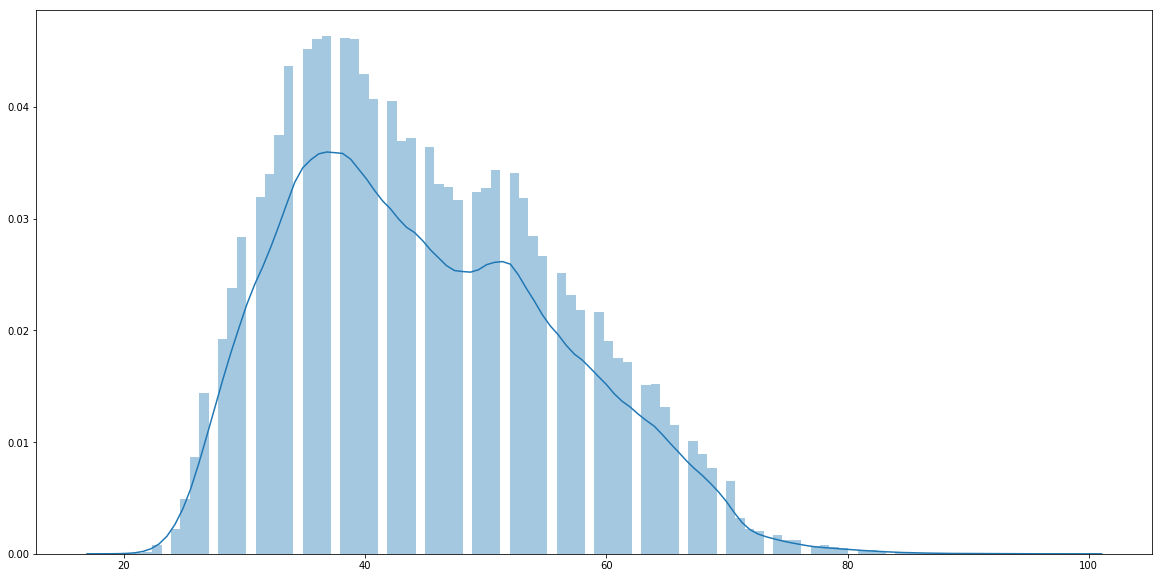

In [20]:
plt.figure(figsize=(20,10))
sns.distplot(x,bins = 100)

In [21]:
1 - scipy.stats.norm(mu, std).cdf(50)

0.32907662600641951